In [1]:
import netgen.gui

from ngsolve import *
from netgen.geom2d import *

import numpy as np
import scipy

optfile ./ng.opt does not exist - using default values
togl-version : 2
OCC module loaded
loading ngsolve library
NGSolve-6.2.2301-102-g8cc04e972
Using Lapack
Including sparse direct solver Pardiso
Including sparse direct solver UMFPACK
Running parallel using 12 thread(s)


Cook's membrane problem

In [2]:
geo = SplineGeometry()

geo.AppendPoint(0,0)
geo.AppendPoint(48,44)
geo.AppendPoint(48,44+8)
geo.AppendPoint(48,44+16)
geo.AppendPoint(0,44)

## "line" -> gerades segment
## 0, 1 -> von 0 nach 1
## bc -> boundary condition
geo.Append(['line',0,1],leftdomain=1,rightdomain=0,bc="free")
geo.Append(['line',1,2],leftdomain=1,rightdomain=0,bc="force")
geo.Append(['line',2,3],leftdomain=1,rightdomain=0,bc="force")
geo.Append(['line',3,4],leftdomain=1,rightdomain=0,bc="free")
geo.Append(['line',4,0],leftdomain=1,rightdomain=0,bc="fix")

geo.Draw()

P1 = (48,44+8)
P2 = (0,44)
P3 = (0,0)

In [3]:
mesh = Mesh(geo.GenerateMesh(maxh=10))
Draw(mesh)

 Generate Mesh from spline geometry


## FE Space, material parameters

In [4]:
V = VectorH1(mesh, order=3, dirichlet="fix")

Emodul = 2.4
nu = 0.49

density = 1e-9

lam = Emodul*nu/(1-nu*nu)
mu = Emodul/2/(1+nu)

Force = 1/16

## Mass and stiffness matrix

assemble separately

In [5]:



## symbolic variables 
U = V.TrialFunction()
DELTAU = V.TestFunction()

GRADU = Grad(U)
EPS = 0.5*(GRADU + GRADU.trans)
DELTAGRADU = Grad(DELTAU)
DELTAEPS = 0.5*(DELTAGRADU + DELTAGRADU.trans)

## Hooke's law
SIGMA = 2*mu*EPS + lam*Trace(EPS)*Id(2)

## bilinear form - container for principle of virtual work integrals
a = BilinearForm(V)
a += SymbolicBFI(InnerProduct(SIGMA, DELTAEPS))

m = BilinearForm(V)
m += SymbolicBFI(density*InnerProduct(U,DELTAU))

a.Assemble()
m.Assemble()



In [6]:
f = LinearForm(V)
f += SymbolicLFI(Force*DELTAU[1], definedon=mesh.Boundaries("force"))
f.Assemble()

## dummy matrix for storing - omega^2 M + K
helpmatrix = a.mat.CreateMatrix()

u = GridFunction(V)

In [15]:
omegalist = []
displist = []

outputfile = open("frequenzlauf.txt", "w")
for omega in np.linspace(0,4000,401):
    helpmatrix.AsVector().data = - omega**2*m.mat.AsVector() + a.mat.AsVector()
    inv = helpmatrix.Inverse(V.FreeDofs(), inverse="pardiso") # "umfpack"

    u.vec.data = inv * f.vec
    
    uP = u(mesh(48,52))[1]
    
    omegalist += [omega]
    displist += [abs(uP)]
    print(f"{omegalist[-1]}\t{displist[-1]}", file=outputfile)
    outputfile.flush()
outputfile.close()

/var/folders/7k/qv8q_x7j7zb1j_js1j824fm00000gq/T/ipykernel_39880/2030780573.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


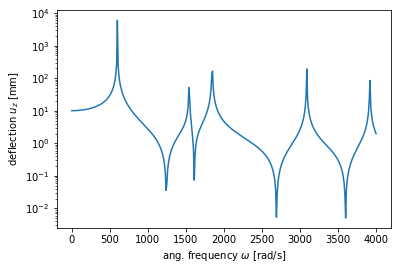

In [16]:
import matplotlib.pyplot as plt
data = np.loadtxt("frequenzlauf.txt")

fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy()
ax.set_xlabel(r"ang. frequency $\omega$ [rad/s]")
ax.set_ylabel(r"deflection $u_z$ [mm]")

ax.plot(data[:,0], data[:,1])
#fig.savefig('bimbeam_freq.png')
fig.show()